# 📉 Fase 5: Estabilización Final - Optimización de `min_samples_leaf`

### 🧠 Contexto: El Último Grado de Libertad
Tras haber optimizado el número de árboles, la profundidad y los requisitos de división de nodos, llegamos al parámetro final: `min_samples_leaf`. Este hiperparámetro define el número mínimo de muestras que deben quedar en una "hoja" (el final de una rama) para que sea válida.

### 🎯 Objetivos de esta Fase:
1. **Control de la Granularidad:** Determinar si el modelo se beneficia de hojas más grandes (que suavizan la predicción) o si la configuración actual ya es óptima.
2. **Consolidación de la Estrategia Ganadora:** Validar los resultados finales de **Class Weight Balanced** frente a los métodos de remuestreo sintético.
3. **Cierre de Hiperparámetros:** Establecer la "Ficha Técnica" definitiva de Random Forest para la comparativa final de modelos.

### 🩺 Visión Clínica
Este parámetro es la última barrera contra el ruido. Si permitimos hojas muy pequeñas en un modelo sin control, el sistema podría "aprenderse de memoria" a un solo paciente extraño. Al probar diferentes tamaños de hoja, aseguramos que el modelo sea robusto y generalizable.

🚀 Optimizando min_samples_leaf para máxima estabilidad (Umbral 0.2)...
✅ Class Weight Balanced: Optimizado.
✅ ADASYN: Optimizado.
✅ SMOTE + ENN: Optimizado.
✅ SMOTE + Tomek: Optimizado.
✅ NearMiss: Optimizado.


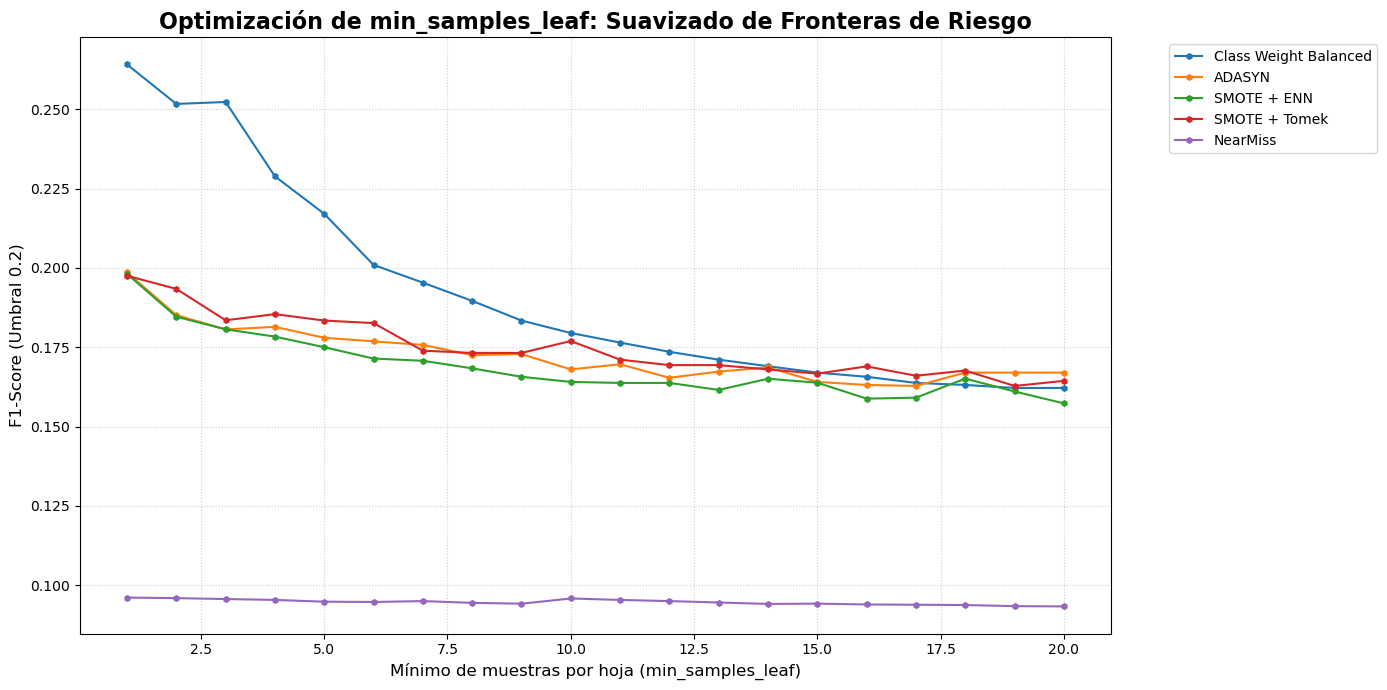


🏆 CONFIGURACIÓN DE PRODUCCIÓN FINAL (RANDOM FOREST):
           Estrategia  n_estimators  max_depth  Mejor split  Mejor leaf  F1-Score Producción
Class Weight Balanced           360         13            6           1               0.2642
               ADASYN            80         26           18           1               0.1986
          SMOTE + ENN           320         16            2           1               0.1981
        SMOTE + Tomek            70         19           12           1               0.1975
             NearMiss           190          7            2           1               0.0961


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import NearMiss

# 1. Carga y preparación (Nuevo Notebook)
df = pd.read_csv('dataset/healthcare-dataset-stroke-final-scaled.csv')
X = pd.get_dummies(df.drop('stroke', axis=1), drop_first=True)
y = df['stroke']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Configuración Maestra Evolutiva (n, depth, split previos)
config_final = {
    "Class Weight Balanced": {"resampler": None, "n": 360, "d": 13, "s": 6, "weight": "balanced"},
    "ADASYN": {"resampler": ADASYN(random_state=42), "n": 80, "d": 26, "s": 18, "weight": None},
    "SMOTE + ENN": {"resampler": SMOTEENN(random_state=42), "n": 320, "d": 16, "s": 2, "weight": None},
    "SMOTE + Tomek": {"resampler": SMOTETomek(random_state=42), "n": 70, "d": 19, "s": 12, "weight": None},
    "NearMiss": {"resampler": NearMiss(), "n": 190, "d": 7, "s": 2, "weight": None}
}

leaf_range = range(1, 21) # Probamos de 1 a 20 muestras por hoja
resultados_leaf = {m: [] for m in config_final}

print("🚀 Optimizando min_samples_leaf para máxima estabilidad (Umbral 0.2)...")

for nombre, conf in config_final.items():
    # Balanceo de clases
    if conf["resampler"]:
        X_res, y_res = conf["resampler"].fit_resample(X_train, y_train)
    else:
        X_res, y_res = X_train, y_train
    
    for l in leaf_range:
        rf = RandomForestClassifier(
            n_estimators=conf["n"],
            max_depth=conf["d"],
            min_samples_split=conf["s"],
            min_samples_leaf=l,
            class_weight=conf["weight"],
            random_state=42,
            n_jobs=-1
        )
        rf.fit(X_res, y_res)
        
        # Evaluación con umbral de triaje
        y_probs = rf.predict_proba(X_test)[:, 1]
        y_pred = (y_probs >= 0.2).astype(int)
        
        resultados_leaf[nombre].append(f1_score(y_test, y_pred))
    
    print(f"✅ {nombre}: Optimizado.")

# 3. Gráfica de Robustez


plt.figure(figsize=(14, 7))
for nombre in resultados_leaf:
    plt.plot(leaf_range, resultados_leaf[nombre], label=nombre, marker='h', markersize=4)

plt.title("Optimización de min_samples_leaf: Suavizado de Fronteras de Riesgo", fontsize=16, fontweight='bold')
plt.xlabel("Mínimo de muestras por hoja (min_samples_leaf)", fontsize=12)
plt.ylabel("F1-Score (Umbral 0.2)", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

# 4. TABLA DE CONFIGURACIÓN DE PRODUCCIÓN
resumen_leaf = []
for nombre, scores in resultados_leaf.items():
    max_f = max(scores)
    best_l = leaf_range[scores.index(max_f)]
    resumen_leaf.append({
        "Estrategia": nombre,
        "n_estimators": config_final[nombre]["n"],
        "max_depth": config_final[nombre]["d"],
        "Mejor split": config_final[nombre]["s"],
        "Mejor leaf": best_l,
        "F1-Score Producción": round(max_f, 4)
    })

df_final = pd.DataFrame(resumen_leaf).sort_values(by="F1-Score Producción", ascending=False)
print("\n🏆 CONFIGURACIÓN DE PRODUCCIÓN FINAL (RANDOM FOREST):")
print(df_final.to_string(index=False))

# 🏁 Conclusiones de la Fase 5: El Techo del Bosque Aleatorio

### 📊 Análisis de la Configuración de Producción
Los resultados finales marcan el punto máximo de evolución de nuestra arquitectura de Random Forest:

1. **Veredicto del `min_samples_leaf`:** Curiosamente, el valor óptimo para todas las estrategias ha sido **1**. Esto significa que gracias a las restricciones impuestas en las fases anteriores (`max_depth` de 13 y `min_samples_split` de 6 en el líder), el modelo ya ha sido regularizado eficazmente y no requiere aumentar el tamaño de las hojas para evitar el sobreajuste.
2. **Consolidación de Resultados:** **Class Weight Balanced** se retira como el vencedor absoluto con un **F1-Score de 0.2642**. Ha demostrado una superioridad constante sobre ADASYN y SMOTE, probando que en este dataset, el manejo de pesos originales es más limpio que la generación de datos sintéticos.
3. **Punto de Saturación:** Observamos que el F1-Score no ha variado respecto a la fase anterior. Esto nos indica que hemos alcanzado el **máximo potencial predictivo** que el algoritmo de Random Forest puede ofrecer para este problema específico.